# Vectorizers Quickstart
## (I don't care why it works, just show me what to do)

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import paths
from src.data import Dataset
from src.user.viz import topic_word_by_class

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings

warnings.simplefilter("ignore")
sns.set()

## Dataset Setup
TODO: move some of this

In [4]:
ds = Dataset.load('20_newsgroups')
print(ds.DESCR)


The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian).

Here are the categories:

 * `alt.atheism`,
 * `comp.graphics`,
 * `comp.os.ms-windows.misc`,
 * `comp.sys.ibm.pc.hardware`,
 * `comp.sys.mac.hardware`,
 * `comp.windows.x`,
 * `misc.forsale`,
 * `rec.autos`,
 * `rec.motorcycles`,
 * `rec.sport.baseball`,
 * `rec.sport.hockey`,
 * `sci.crypt`,
 * `sci.electronics`,
 * `sci.med`,
 * `sci.space`,
 * `soc.religion.christian`,
 * `talk.politics.guns`,
 * `talk.politics.mideast`,
 * `talk.politics.misc`,
 * `talk.religion.misc`

The current version is obtained by wrapping `sklearn.datasets.fetch_20newsgroups

In [5]:
long_enough = [len(t) > 200 for t in ds.data]
targets = np.array(ds.target)[long_enough]
news_data = [t for t in ds.data if len(t) > 200]

In [6]:
religion = ("alt.atheism", "talk.religion.misc", "soc.religion.christian")
politics = ("talk.politics.misc", "talk.politics.mideast", "talk.politics.guns")
sport = ("rec.sport.baseball", "rec.sport.hockey")
comp = (
    "comp.graphics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware",
    "comp.windows.x",
)
sci = (
    "sci.crypt",
    "sci.electronics",
    "sci.med",
    "sci.space",
)
misc = (
    "misc.forsale",
    "rec.autos",
    "rec.motorcycles",
)

In [7]:
color_key = {}
for l, c in zip(religion, sns.color_palette("Blues", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(politics, sns.color_palette("Purples", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(comp, sns.color_palette("YlOrRd", 5)):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sci, sns.color_palette("light:teal", 5)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(sport, sns.color_palette("light:#660033", 4)[1:3]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
for l, c in zip(misc, sns.color_palette("YlGn", 4)[1:]):
    color_key[l] = matplotlib.colors.rgb2hex(c)
color_key["word"] = "#777777bb"

## Tokenize

In [8]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True)
sk_word_tokenize = cv.build_tokenizer()
sk_preprocesser = cv.build_preprocessor()
tokenize = lambda doc: sk_word_tokenize(sk_preprocesser(doc))
tokenized_news = [tokenize(doc) for doc in news_data]

CPU times: user 1.44 s, sys: 111 ms, total: 1.55 s
Wall time: 1.67 s


## Word Embedding

In [9]:
%%time
word_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=20,          
    window_functions='variable',
    kernel_functions='geometric',            
    n_iter = 0,
    normalize_windows=True,
).fit(tokenized_news)
word_vectors = word_vectorizer.reduce_dimension(dimension=160, algorithm="randomized")

CPU times: user 5min 37s, sys: 14.7 s, total: 5min 52s
Wall time: 6min 4s


In [10]:
## insert a viz?

## Document Embedding

Approximate Wasserstein Embedding

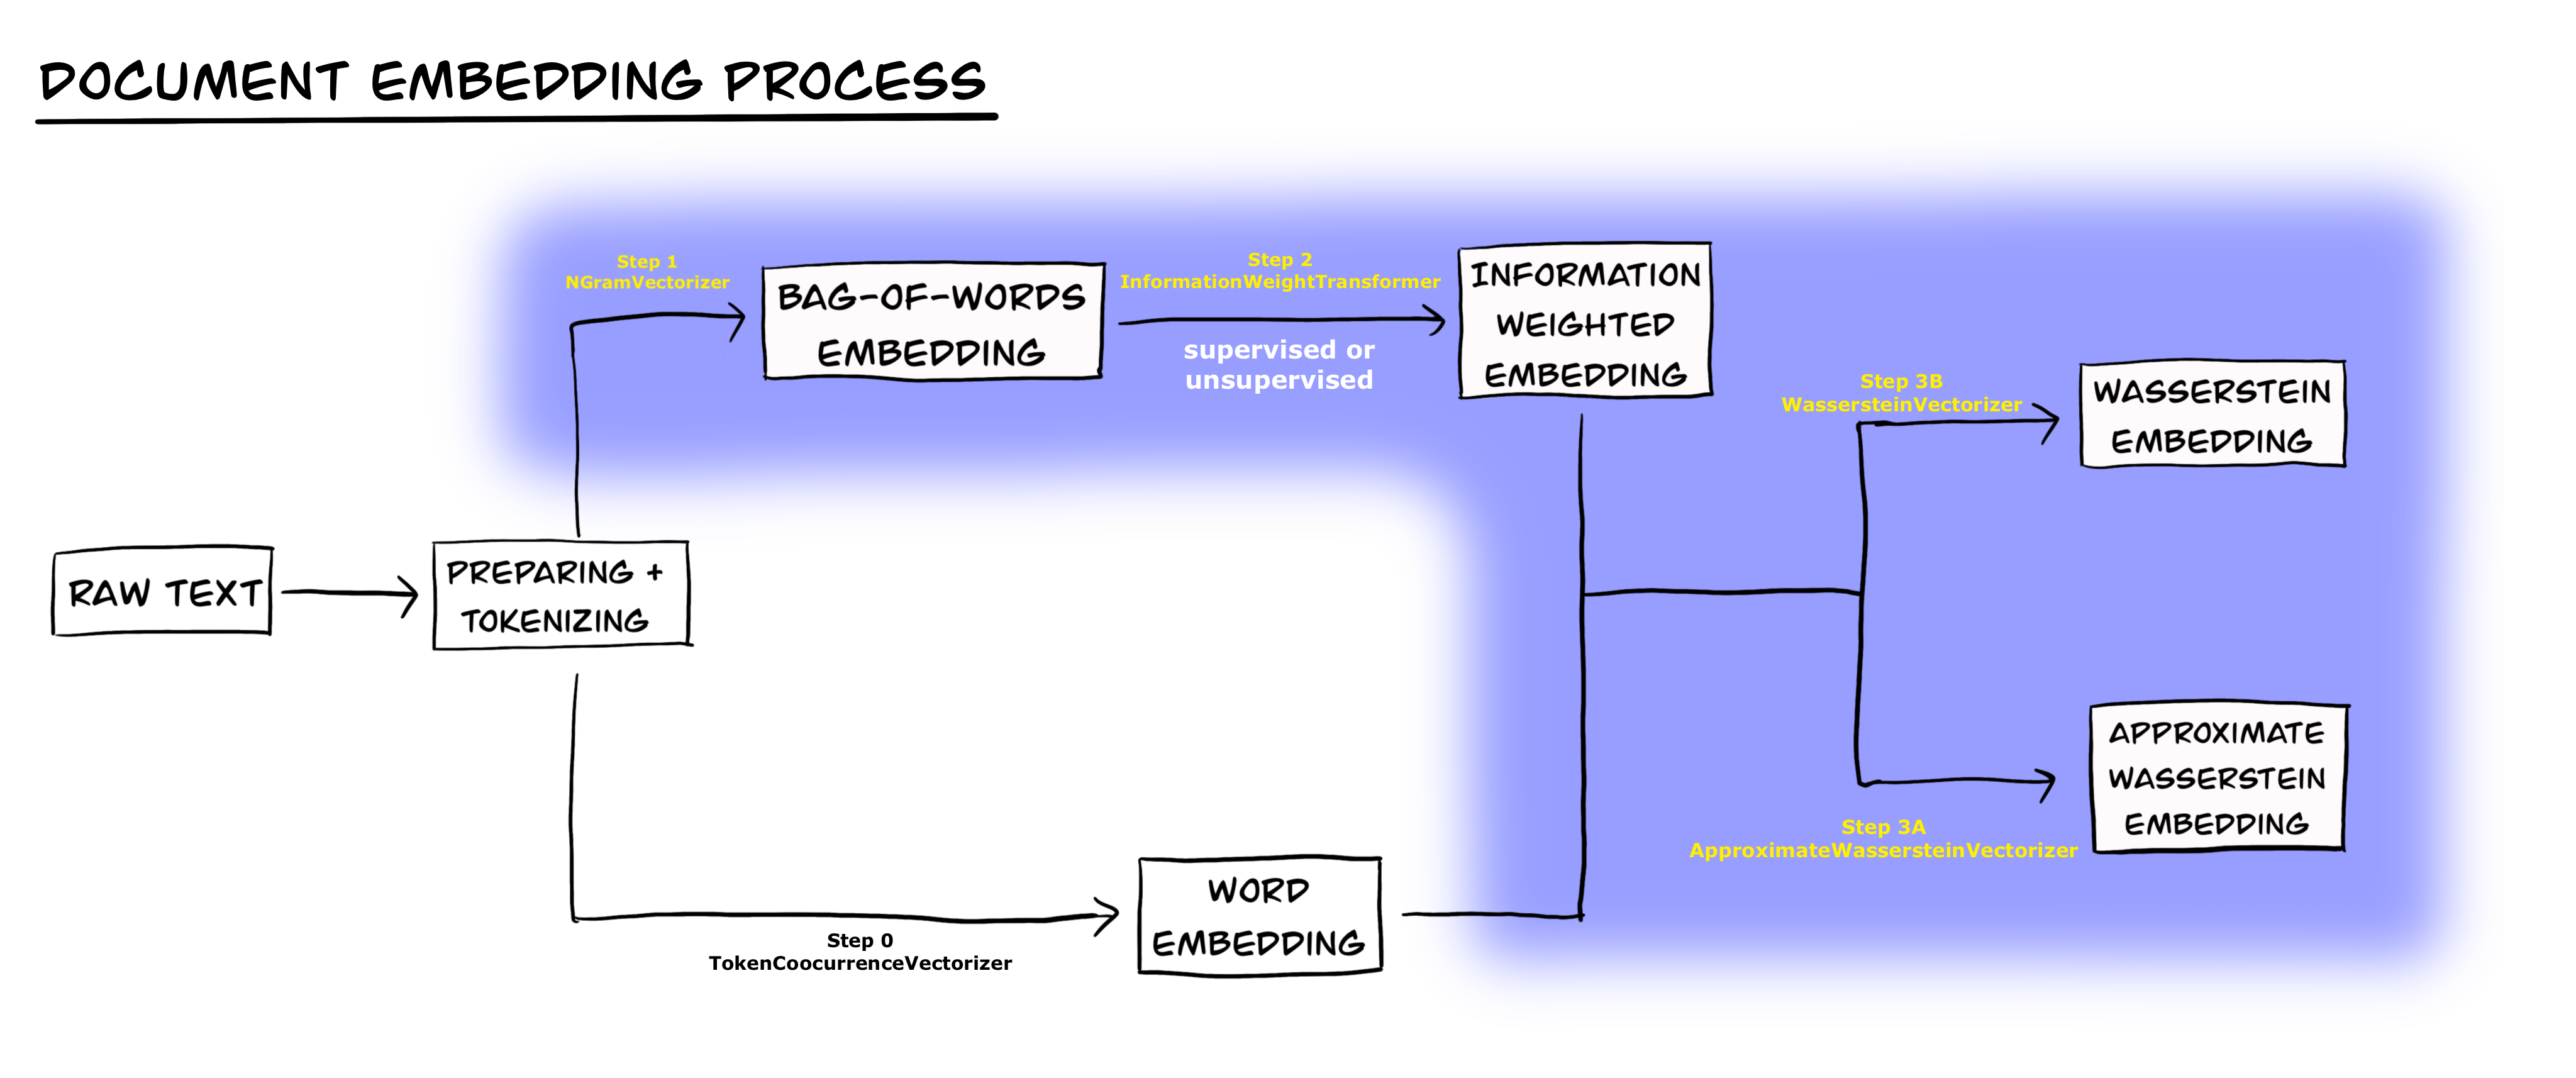

In [11]:
%%time
bow_vectors = vectorizers.NgramVectorizer(
    token_dictionary=word_vectorizer.token_label_dictionary_
).fit_transform(tokenized_news)

CPU times: user 23.7 s, sys: 831 ms, total: 24.5 s
Wall time: 38 s


In [12]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_doc_vectors = info_transformer.fit_transform(bow_vectors)

CPU times: user 9.84 s, sys: 410 ms, total: 10.3 s
Wall time: 18.1 s


In [13]:
%%time
awe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_doc_vectors = awe_vectorizer.fit_transform(info_doc_vectors, vectors=word_vectors)

CPU times: user 9.54 s, sys: 890 ms, total: 10.4 s
Wall time: 14.2 s


In [14]:
%%time
awe_doc_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_doc_vectors)

CPU times: user 2min 14s, sys: 6.06 s, total: 2min 20s
Wall time: 4min 19s


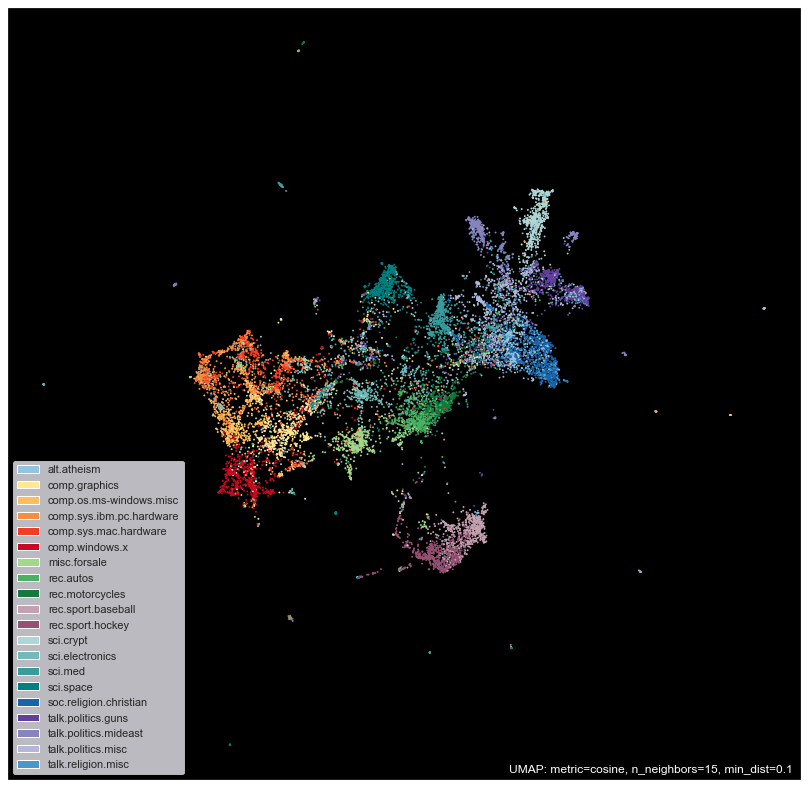

In [15]:
umap.plot.points(
    awe_doc_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);

## Topic Embedding

In addition to existing `awe_doc_vectors`

In [16]:
awe_word_vectors = awe_vectorizer.transform(info_transformer.transform(scipy.sparse.eye(word_vectors.shape[0])))

In [17]:
%%time
awe_topic_mapper = umap.UMAP(metric="cosine", random_state=42).fit(np.vstack([awe_doc_vectors, awe_word_vectors]))

CPU times: user 2min 37s, sys: 8.06 s, total: 2min 45s
Wall time: 4min 29s


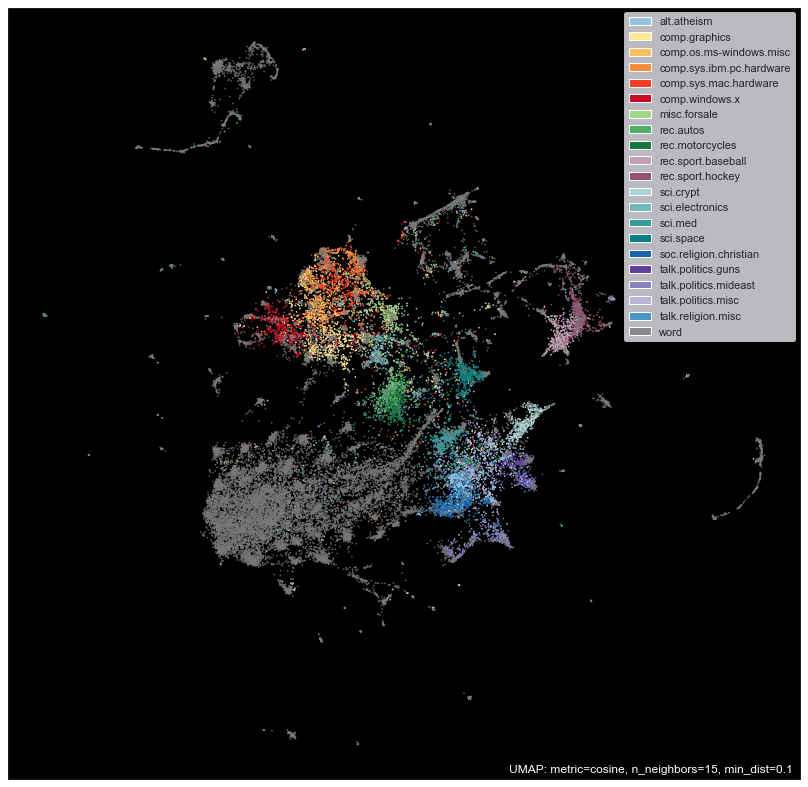

In [18]:
umap.plot.points(
    awe_topic_mapper,
    labels=np.array([ds.metadata['target_names'][x] for x in targets] + ["word"] * awe_word_vectors.shape[0]),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);

CPU times: user 7min 40s, sys: 48.7 s, total: 8min 28s
Wall time: 13min 12s


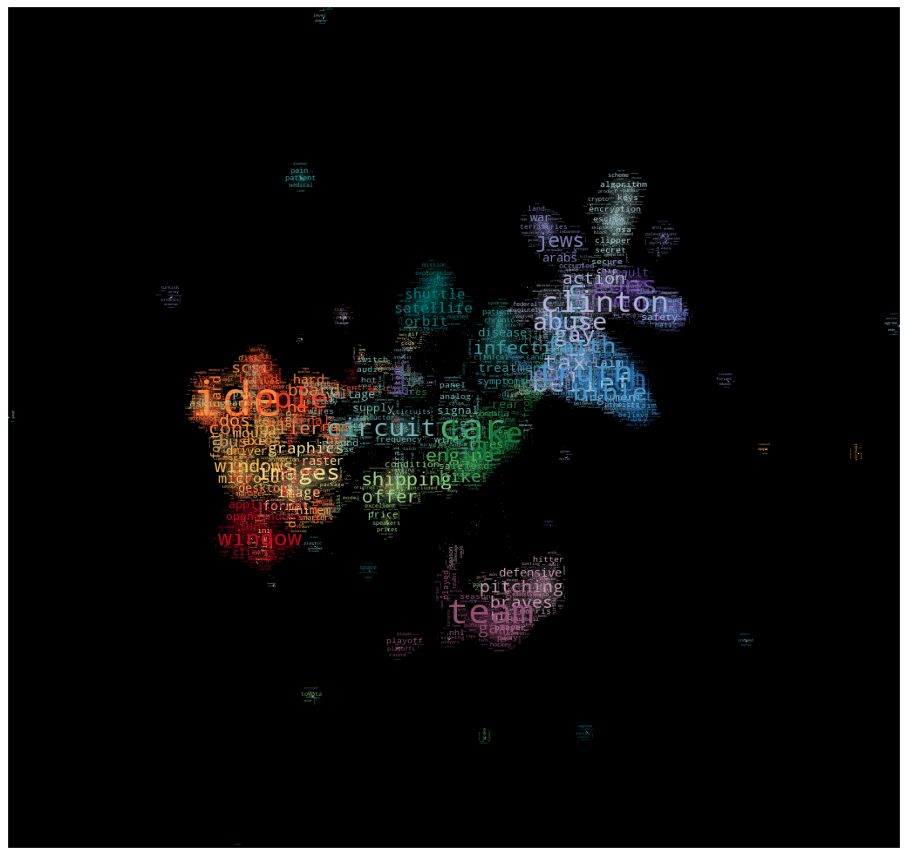

In [19]:
%%time
topic_word_by_class(
    awe_doc_vectors,
    awe_word_vectors,
    targets, 
    ds.metadata['target_names'],
    lambda x: word_vectorizer.token_index_dictionary_[x],
    color_key,
    background="black"
)

In [20]:
## see other notebooks for further visualization examples